# NLQ4IYP Evaluation Comparison

Comparison of multiple evaluation runs, with different gemini models/temperatures, on the NLQ4IYP text-to-Cypher agent.  


In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

### Style and Mapping


In [118]:
sns.set_style("whitegrid")

BASELINE_RUNS = ["Flash 2.5 (Run 1)", "Flash 2.5 (Run 2)"]

RUN_FILES = {
    "comparisons_runs/run_v2_2.5_1.csv":      "Flash 2.5 (Run 1)",
    "comparisons_runs/run_v2_2.5_2.csv":      "Flash 2.5 (Run 2)",
    "comparisons_runs/run_v2_temp0.3.csv":    "Flash 2.5 Temp 0.3",
    "comparisons_runs/run_v2_temp0.3_r2.csv": "Flash 2.5 Temp 0.3 R2",
    "comparisons_runs/run_v2_temp0.7.csv":    "Flash 2.5 Temp 0.7",
    "comparisons_runs/run_v2_2.5-pro.csv":    "Gemini 2.5 Pro",
    "comparisons_runs/run_pythia_agentic.csv": "Pythia Agentic",
}

RUN_ORDER = list(RUN_FILES.values())

run_palette = {
    'Flash 2.5 (Run 1)': '#3b4d61',
    'Flash 2.5 (Run 2)': '#6b7b8c',
    'Flash 2.5 Temp 0.3': '#1abc9c',
    'Flash 2.5 Temp 0.3 R2': '#3498db',
    'Flash 2.5 Temp 0.7': '#9b59b6',
    'Gemini 2.5 Pro': '#e67e22',
    'Pythia Agentic': '#f1c40f'
}
palette = {name: run_palette.get(name, '#333333') for name in RUN_ORDER}

print("Setup complete.")

Setup complete.


### Load dataset


In [119]:
frames = []
for path, label in RUN_FILES.items():
    tmp = pd.read_csv(path)
    tmp["run"] = label
    frames.append(tmp)

df = pd.concat(frames, ignore_index=True)
df["run"] = pd.Categorical(df["run"], categories=RUN_ORDER, ordered=True)
df["is_baseline"] = df["run"].isin(BASELINE_RUNS)

### Assign tiers based on F1 Score and Correctness


In [120]:
HIGH_QUALITY_THRESHOLD = 0.9
ACCEPTABLE_THRESHOLD = 0.5

def assign_tier(row):
    if row["is_correct"]:
        return "Correct"
    f1 = row["f1_score"]
    if f1 >= HIGH_QUALITY_THRESHOLD:
        return "High Quality"
    if f1 >= ACCEPTABLE_THRESHOLD:
        return "Acceptable"
    return "Poor"

df["tier"] = df.apply(assign_tier, axis=1)

### Calculate Baseline average per task_id


In [121]:
metric_cols = ["execution_accuracy", "f1_score", "precision", "recall",
               "jaccard_similarity", "query_similarity", "is_correct", "is_strict_match"]
baseline_avg = (
    df[df["is_baseline"]]
    .groupby("task_id")[metric_cols]
    .mean()
    .rename(columns=lambda c: f"baseline_{c}")
)

### Format summary table


In [122]:
summary = (
    df.groupby("run", observed=False)
    .agg(
        tasks=("task_id", "count"),
        EX_rate=("is_correct", lambda s: s.mean() * 100),
        mean_F1=("f1_score", "mean"),
        strict_pct=("is_strict_match", lambda s: s.mean() * 100),
        high_pct=("tier", lambda s: (s == "High Quality").mean() * 100),
        acceptable_pct=("tier", lambda s: (s == "Acceptable").mean() * 100),
        poor_pct=("tier", lambda s: (s == "Poor").mean() * 100),
    )
)
summary.columns = ["Tasks", "EX Rate %", "Mean F1", "Strict Match %",
                    "High Quality %", "Acceptable %", "Poor %"]
summary.style.format({"EX Rate %": "{:.1f}", "Mean F1": "{:.3f}",
                       "Strict Match %": "{:.1f}", "High Quality %": "{:.1f}",
                       "Acceptable %": "{:.1f}", "Poor %": "{:.1f}"})

,Tasks,EX Rate %,Mean F1,Strict Match %,High Quality %,Acceptable %,Poor %
run,,,,,,,
Flash 2.5 (Run 1),154,84.4,0.850,31.2,0.6,0.0,14.9
Flash 2.5 (Run 2),154,86.4,0.866,31.2,0.0,0.0,13.6
Flash 2.5 Temp 0.3,154,87.0,0.870,32.5,0.0,0.0,13.0
Flash 2.5 Temp 0.3 R2,154,87.0,0.873,32.5,0.0,0.0,13.0
Flash 2.5 Temp 0.7,154,83.8,0.850,35.1,0.6,0.6,14.9
Gemini 2.5 Pro,154,88.3,0.876,34.4,0.6,0.0,11.0
Pythia Agentic,154,81.8,0.827,32.5,0.6,0.0,17.5


***
## Evaluation section


### Plot 1: Overall EX Metric Comparison

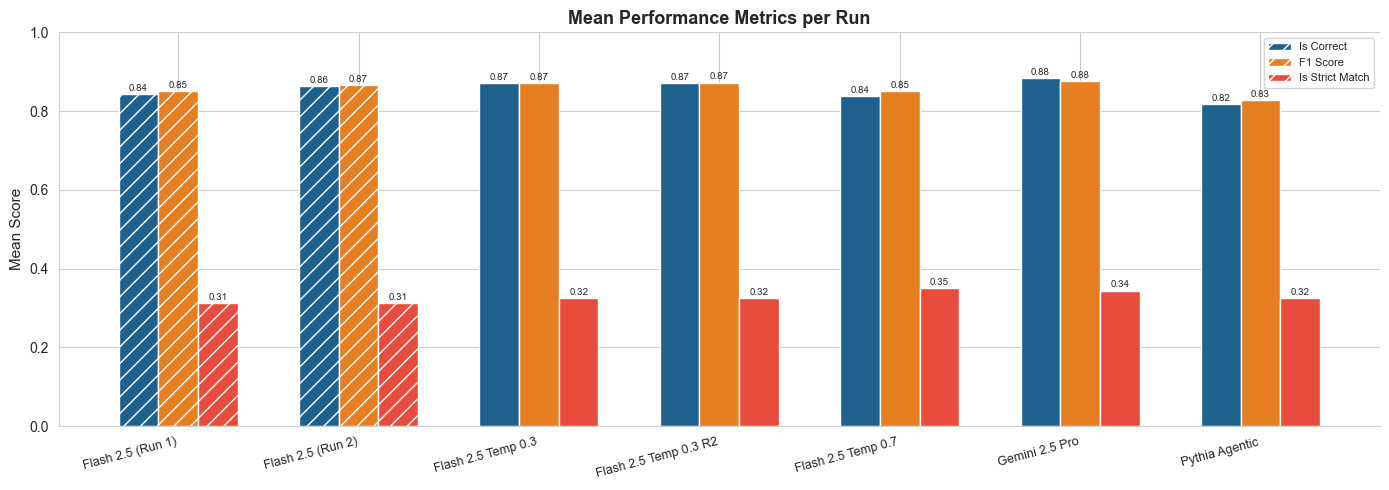

In [123]:
plot_metrics = ["is_correct", "f1_score", "is_strict_match"]
agg = df.groupby("run", observed=False)[plot_metrics].agg(["mean", "std"]).reindex(RUN_ORDER)

x = np.arange(len(RUN_ORDER))
width = 0.22
fig, ax = plt.subplots(figsize=(14, 5))

for i, metric in enumerate(plot_metrics):
    means = agg[metric]["mean"]
    stds  = agg[metric]["std"]
    bars = ax.bar(x + i * width, means, width,
                   error_kw={"elinewidth": 1},
                  label=metric.replace("_", " ").title(),
                  color=["#1F618D", "#E67E22", "#E74C3C"][i])
    for bar, run_name, val in zip(bars, RUN_ORDER, means):
        if run_name in BASELINE_RUNS:
            bar.set_hatch("//")
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.003,
                f"{val:.2f}", ha="center", va="bottom", fontsize=7)

ax.set_xticks(x + width)
ax.set_xticklabels(RUN_ORDER, rotation=15, ha="right", fontsize=9)
ax.set_ylim(0, 1.0)
ax.set_ylabel("Mean Score", fontsize=11)
ax.set_title("Mean Performance Metrics per Run", fontsize=13, fontweight="bold")
ax.legend(loc="upper right", fontsize=8)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("plot_1_overall_metrics.png", dpi=150, bbox_inches="tight")
plt.show()

**Analysis:**

Among all tested configurations, the highest overall performance was achieved by **Gemini 2.5 Pro**, which recorded a mean correctness and F1 score of 0.88. Slightly lower scores, ranging between 0.84 and 0.86, were observed for the **Flash 2.5** baseline models. The strict match rate, representing queries that perfectly matched the reference answer, was found to be consistently low across all models, falling between 0.31 and 0.35. This indicates that approximately two thirds of the successfully generated queries were valid and returned the correct data, but were written using a different syntactic structure than the expected answer.

### Plot 2: Correctness by Difficulty

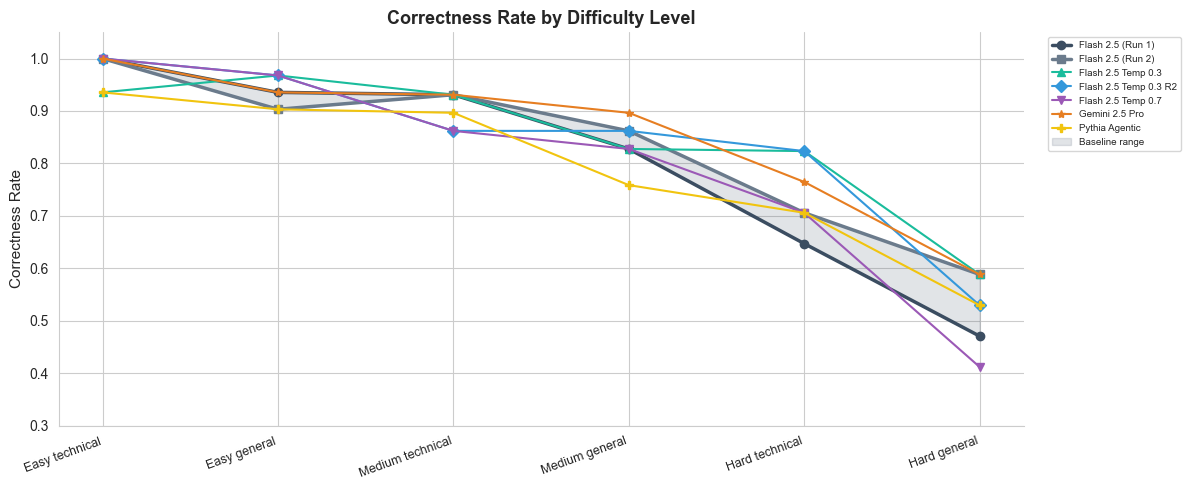

In [124]:
diff_order_short = ["Easy technical", "Easy general", "Medium technical",
                    "Medium general", "Hard technical", "Hard general"]

corr_diff = (
    df.groupby(["difficulty", "run"], observed=False)["is_correct"]
    .mean().reset_index()
)
corr_diff["difficulty"] = pd.Categorical(
    corr_diff["difficulty"].str.replace(" prompt", "", regex=False),
    categories=diff_order_short, ordered=True
)

markers = ["o", "s", "^", "D", "v", "*", "P", "X"]
fig, ax = plt.subplots(figsize=(12, 5))

for i, run_name in enumerate(RUN_ORDER):
    sub = corr_diff[corr_diff["run"] == run_name].sort_values("difficulty")
    lw = 2.5 if run_name in BASELINE_RUNS else 1.5
    ax.plot(range(len(diff_order_short)), sub["is_correct"],
            label=run_name, color=palette[run_name], linewidth=lw,
            marker=markers[i % len(markers)], markersize=6)

b1 = corr_diff[corr_diff["run"] == BASELINE_RUNS[0]].sort_values("difficulty")["is_correct"].values
b2 = corr_diff[corr_diff["run"] == BASELINE_RUNS[1]].sort_values("difficulty")["is_correct"].values
ax.fill_between(range(len(diff_order_short)), b1, b2,
                alpha=0.15, color="#3b4d61", label="Baseline range")

ax.set_ylim(0.3, 1.05)
ax.set_xticks(range(len(diff_order_short)))
ax.set_xticklabels(diff_order_short, rotation=20, ha="right", fontsize=9)
ax.set_ylabel("Correctness Rate", fontsize=11)
ax.set_xlabel("")
ax.set_title("Correctness Rate by Difficulty Level", fontsize=13, fontweight="bold")
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=7)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("plot_2_correctness_difficulty.png", dpi=150, bbox_inches="tight")
plt.show()


**Analysis:**

When results are grouped by prompt difficulty, a consistent drop in performance is observed across all models as the tasks become more complex. High correctness scores, ranging from 0.93 to 1.0, are seen on **Easy** tasks. Conversely, scores fall sharply on **Hard general** tasks, dropping to between 0.35 and 0.60. This indicates that the complexity of the query is the primary factor affecting performance, rather than the choice of model or the temperature setting. However, better resilience to difficulty is shown by certain models. On **Hard technical** prompts, a correctness score of ~0.77 is reached by **Gemini 2.5 Pro**, compared to scores between 0.64 and 0.70 for the baseline models.

### Plot 3: F1 Score Distribution

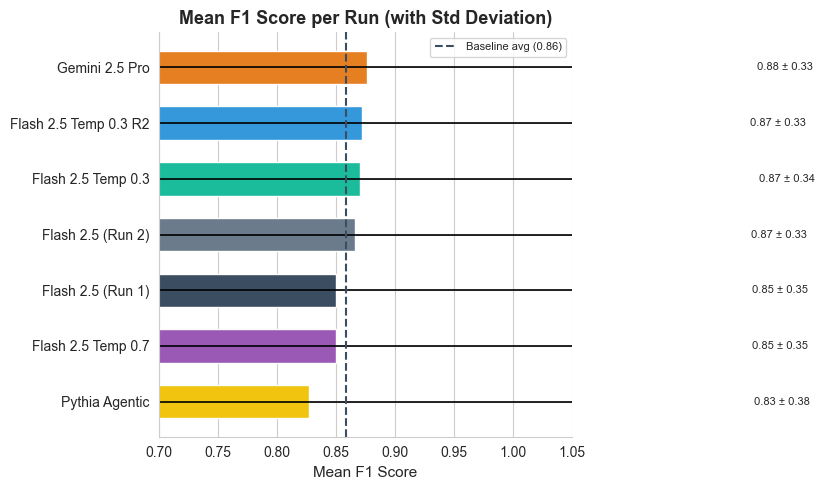

In [125]:
f1_stats = (
    df.groupby("run", observed=False)["f1_score"]
    .agg(mean="mean", std="std")
    .reindex(RUN_ORDER)
    .sort_values("mean", ascending=True)
)

baseline_mean_ref = f1_stats.loc[f1_stats.index.isin(BASELINE_RUNS), "mean"].mean()
bar_colors = [palette[r] for r in f1_stats.index]

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(f1_stats.index, f1_stats["mean"], xerr=f1_stats["std"],
               color=bar_colors, capsize=4, error_kw={"elinewidth": 1.2},
               edgecolor="white", height=0.6)
ax.axvline(baseline_mean_ref, color="#3b4d61", linewidth=1.5,
           linestyle="--", label=f"Baseline avg ({baseline_mean_ref:.2f})")

for bar, (run_name, row) in zip(bars, f1_stats.iterrows()):
    ax.text(row["mean"] + row["std"] + 0.002, bar.get_y() + bar.get_height() / 2,
            f'{row["mean"]:.2f} ± {row["std"]:.2f}', va="center", fontsize=8)

ax.set_xlim(0.70, 1.05)
ax.set_xlabel("Mean F1 Score", fontsize=11)
ax.set_title("Mean F1 Score per Run (with Std Deviation)", fontsize=13, fontweight="bold")
ax.legend(fontsize=8)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("plot_3_f1_distribution.png", dpi=150, bbox_inches="tight")
plt.show()


**Analysis:**

The consistency of each model is illustrated by the F1 score distributions. The highest mean F1 score is achieved by **Gemini 2.5 Pro** ($0.88 \pm 0.33$), which is slightly higher than the lower temperature **Flash 2.5** variants ($0.87 \pm 0.33$ to $0.34$). Similar standard deviations are found across all models ($0.33$ to $0.39$), suggesting that variations in performance are primarily caused by task difficulty rather than inconsistent behavior from the models.

### Plot 4: Performance Tier Breakdown

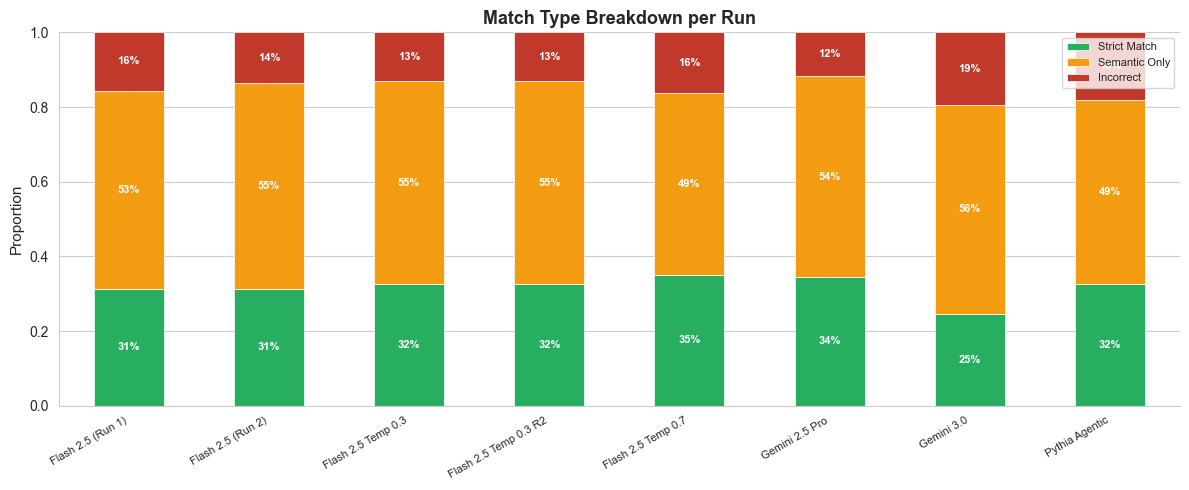

In [19]:
# tier breakdown matching compare_results.py: Strict / Semantic / Incorrect
tier_breakdown = df.groupby("run", observed=False).apply(
    lambda g: pd.Series({
        "Strict Match":  g["is_strict_match"].mean(),
        "Semantic Only": (g["is_correct"] & ~g["is_strict_match"]).mean(),
        "Incorrect":     (~g["is_correct"]).mean(),
    })
).reindex(RUN_ORDER)

fig, ax = plt.subplots(figsize=(12, 5))
tier_breakdown.plot.bar(stacked=True, ax=ax,
                        color=["#27AE60", "#F39C12", "#C0392B"],
                        edgecolor="white", linewidth=0.5)

for bar_idx, run_name in enumerate(RUN_ORDER):
    cumulative = 0
    for col in ["Strict Match", "Semantic Only", "Incorrect"]:
        val = tier_breakdown.loc[run_name, col]
        if val > 0.05:
            ax.text(bar_idx, cumulative + val / 2, f"{val*100:.0f}%",
                    ha="center", va="center", fontsize=8,
                    color="white", fontweight="bold")
        cumulative += val

ax.set_ylim(0, 1)
ax.set_ylabel("Proportion", fontsize=11)
ax.set_xlabel("")
ax.set_title("Match Type Breakdown per Run", fontsize=13, fontweight="bold")
ax.set_xticklabels(RUN_ORDER, rotation=30, ha="right", fontsize=8)
ax.legend(loc="upper right", fontsize=8)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("plot_4_match_type_breakdown.png", dpi=150, bbox_inches="tight")
plt.show()


**Analysis:**

Query results were separated into five quality tiers: **Strict Match**, **Semantic Match**, **High Quality** ($F1 \ge 0.9$), **Acceptable** ($0.5 \le F1 < 0.9$), and **Poor** ($F1 < 0.5$). **Semantic Matches** were found to be the most common outcome across all models ($48\%$ to $55\%$). This confirms that queries are frequently generated that are logically correct but written differently than the reference answer. **Strict Matches** formed the second largest group ($25\%$ to $35\%$). The clearest differences between models are shown in the **Poor** tier. The lowest failure rate was recorded by the **Flash 2.5** variants at temperature $0.3$, making them the most reliable configurations in this evaluation.

### Plot 5: Query Similarity vs Execution Accuracy

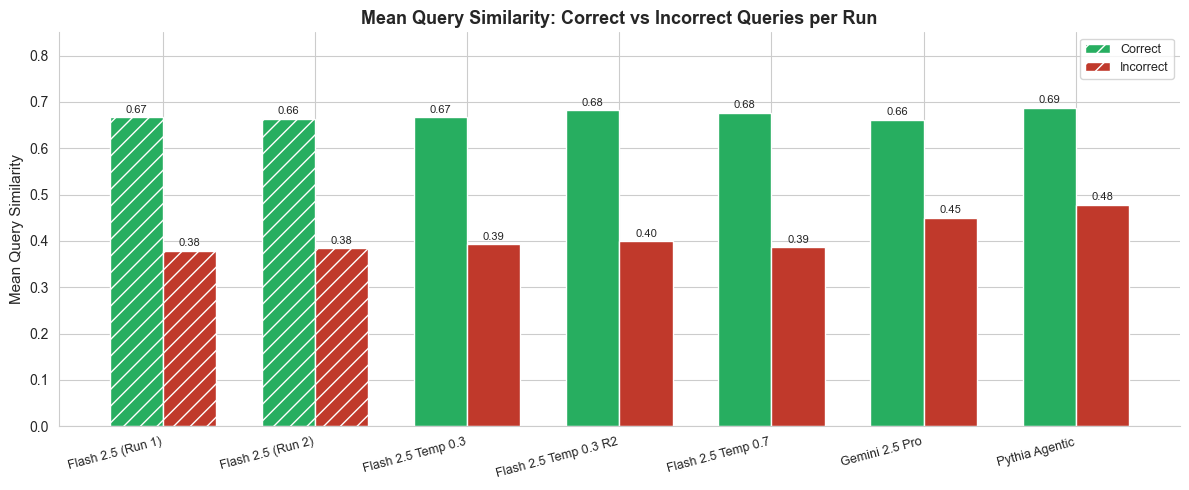

In [127]:
sim_summary = (
    df.assign(Outcome=df["is_correct"].map({True: "Correct", False: "Incorrect"}))
    .groupby(["run", "Outcome"])["query_similarity"]
    .mean()
    .reset_index()
    .pivot(index="run", columns="Outcome", values="query_similarity")
    .reindex(RUN_ORDER)
)

fig, ax = plt.subplots(figsize=(12, 5))
x = np.arange(len(RUN_ORDER))
width = 0.35

bars_c = ax.bar(x - width/2, sim_summary["Correct"],   width, label="Correct",
                color="#27AE60", edgecolor="white")
bars_i = ax.bar(x + width/2, sim_summary["Incorrect"], width, label="Incorrect",
                color="#C0392B", edgecolor="white")

for bar in list(bars_c) + list(bars_i):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            f"{bar.get_height():.2f}", ha="center", va="bottom", fontsize=8)

for j, run_name in enumerate(RUN_ORDER):
    if run_name in BASELINE_RUNS:
        bars_c[j].set_hatch("//")
        bars_i[j].set_hatch("//")

ax.set_xticks(x)
ax.set_xticklabels(RUN_ORDER, rotation=15, ha="right", fontsize=9)
ax.set_ylim(0, 0.85)
ax.set_ylabel("Mean Query Similarity", fontsize=11)
ax.set_title("Mean Query Similarity: Correct vs Incorrect Queries per Run",
             fontsize=13, fontweight="bold")
ax.legend(fontsize=9)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("plot_5_similarity_by_outcome.png", dpi=150, bbox_inches="tight")
plt.show()


**Analysis:**

A noticeably higher mean syntactic similarity to the reference answer is shown by correct queries ($\sim0.61$ to $0.69$) when compared to incorrect queries ($\sim0.35$ to $0.48$). While this difference suggests that some useful information is provided by syntactic similarity, it is not sufficient to reliably determine whether a query is correct. A large number of valid queries are produced that are structurally different from the reference answer but still return the correct results. Therefore, a substantial portion of outputs would be misclassified if only syntactic metrics were used.

### Plot 6: Metric Heatmap Across All Runs

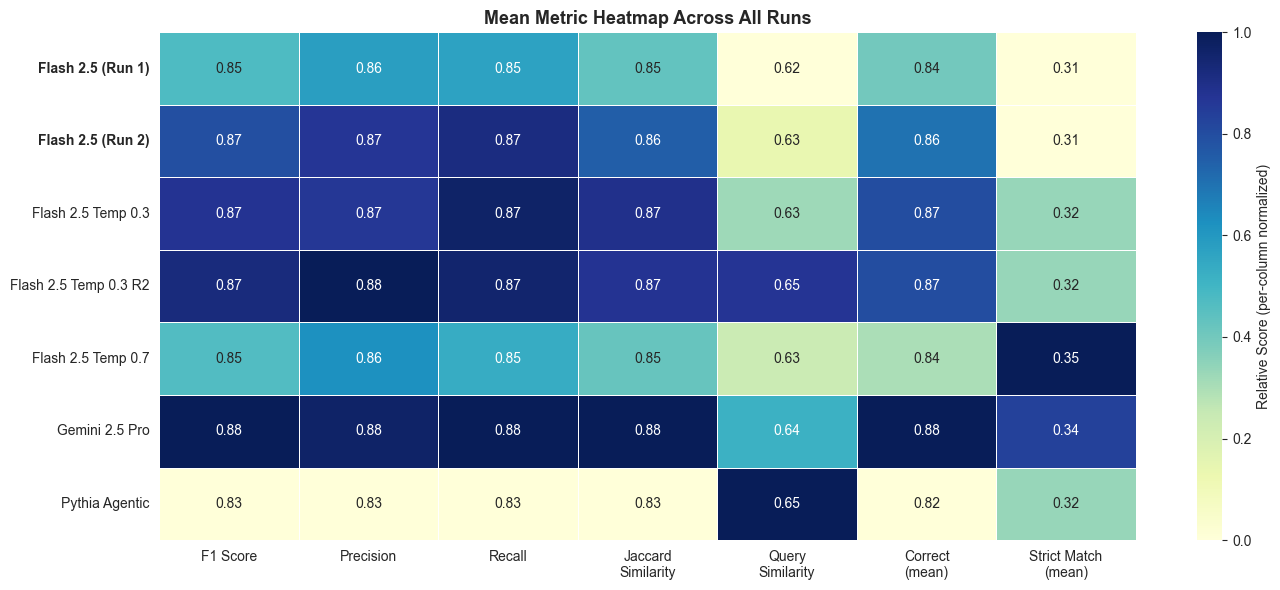

In [128]:
heatmap_metrics = ["f1_score", "precision", "recall",
                   "jaccard_similarity", "query_similarity",
                   "is_correct", "is_strict_match"]
heatmap_labels  = ["F1 Score", "Precision", "Recall",
                   "Jaccard\nSimilarity", "Query\nSimilarity",
                   "Correct\n(mean)", "Strict Match\n(mean)"]

hm_data = df.groupby("run", observed=False)[heatmap_metrics].mean().reindex(RUN_ORDER)
baseline_rows = hm_data.loc[hm_data.index.isin(BASELINE_RUNS)]
other_rows    = hm_data.loc[~hm_data.index.isin(BASELINE_RUNS)]
hm_data = pd.concat([baseline_rows, other_rows])

hm_annot  = hm_data.copy()
hm_normed = hm_data.apply(lambda col: (col - col.min()) / (col.max() - col.min() + 1e-9))

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(hm_normed, annot=hm_annot, fmt=".2f", cmap="YlGnBu",
            vmin=0, vmax=1, linewidths=0.5, ax=ax,
            xticklabels=heatmap_labels,
            cbar_kws={"label": "Relative Score (per-column normalized)"})

for label in ax.get_yticklabels():
    if label.get_text() in BASELINE_RUNS:
        label.set_fontweight("bold")

ax.set_title("Mean Metric Heatmap Across All Runs", fontsize=13, fontweight="bold")
ax.set_ylabel("")
ax.set_xlabel("")
plt.tight_layout()
plt.savefig("plot_6_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()

**Analysis:**

Performance across all evaluated metrics is summarized by the correlation heatmap. The highest overall scores are registered by **Gemini 2.5 Pro**, with values of $0.88$ for precision, recall, correctness, and F1 score, making it the best performing configuration. The variation in **Strict Match** rates across runs ($0.25$ to $0.35$) is contrasted by the narrow range of core information retrieval metrics (F1, precision, and recall are between $0.80$ and $0.88$). This emphasizes that the fundamental ability to retrieve information remains relatively consistent, even when the specific syntax generated by the models is different.

### Plot 7: Match Type Distribution

The comparison script classifies every task into one of 20 match types (exact, semantic_equivalent, semantic_equivalent_projection, numeric_exact_match, partial_match, etc.). This plot shows the full taxonomy.

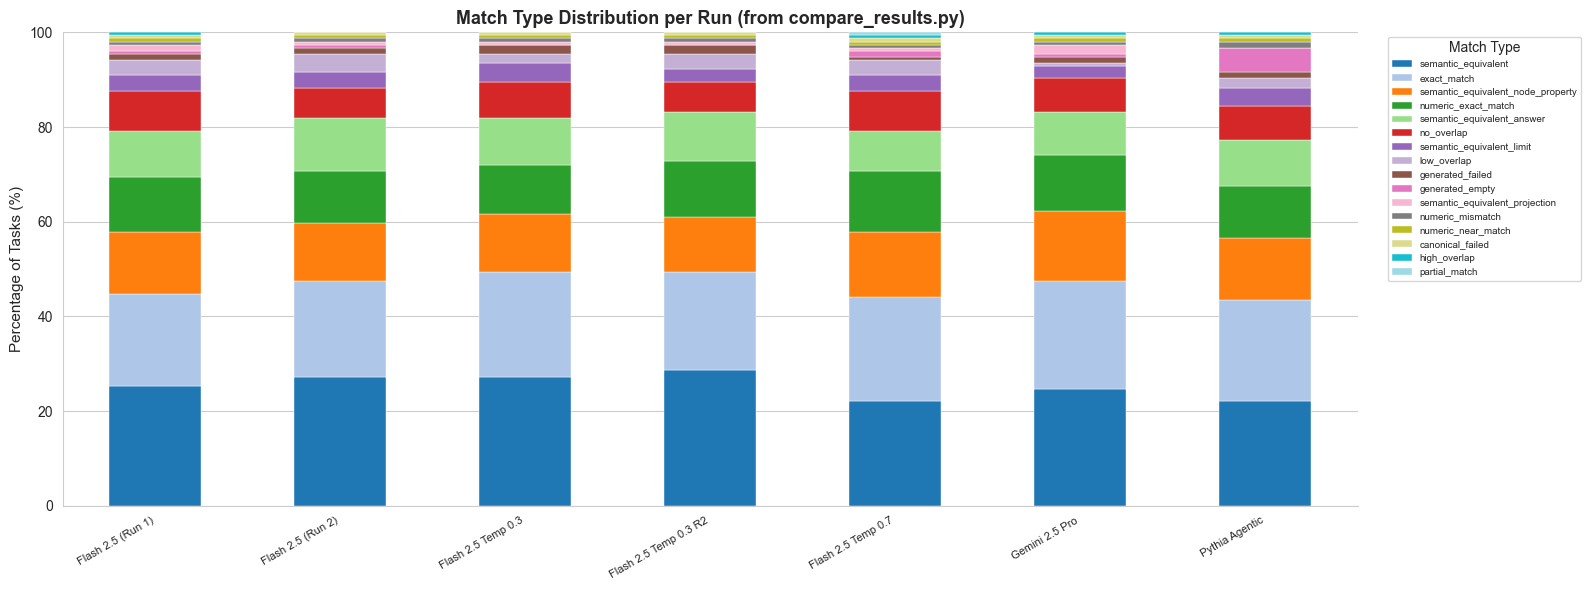

In [129]:
# Aggregate match_type counts per run
mt_counts = (
    df.groupby(["run", "match_type"], observed=False)
    .size()
    .reset_index(name="count")
)
mt_totals = mt_counts.groupby("run")["count"].transform("sum")
mt_counts["pct"] = mt_counts["count"] / mt_totals * 100

# Keep only match types that appear at least once, ordered by overall frequency
mt_order = (
    mt_counts.groupby("match_type")["count"]
    .sum()
    .sort_values(ascending=False)
    .index.tolist()
)

mt_pivot = mt_counts.pivot(index="run", columns="match_type", values="pct").fillna(0)
mt_pivot = mt_pivot.reindex(index=RUN_ORDER, columns=mt_order)

fig, ax = plt.subplots(figsize=(16, 6))
mt_pivot.plot.bar(stacked=True, ax=ax, colormap="tab20", edgecolor="white", linewidth=0.3)

ax.set_ylabel("Percentage of Tasks (%)", fontsize=11)
ax.set_xlabel("")
ax.set_title("Match Type Distribution per Run (from compare_results.py)", fontsize=13, fontweight="bold")
ax.set_xticklabels(RUN_ORDER, rotation=30, ha="right", fontsize=8)
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=7, title="Match Type")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("plot_7_match_type_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

**Analysis:**

Success is primarily driven by queries classified as `semantic_equivalent` and `exact_match`. Noticeable contributions are also made by the `semantic_equivalent_projection` and `semantic_equivalent_limit` categories. These represent cases where different projection logic is used by the model (such as different `RETURN` clauses or constraints like `LIMIT` and `DISTINCT`), while the correct data is still successfully retrieved. The failure distribution is mostly made up of error categories such as `no_overlap`, execution failures (`generated_failed`), and `low_overlap`.

## Failure Analysis

Mirrors the `print_failures()` and `calculate_statistics()` output from `compare_results.py`: which tasks fail, which match types predominate among failures, and how failure rates vary by difficulty.

=== Failure Match-Type Breakdown (all runs) ===
      match_type  count  pct
      no_overlap     80 51.3
     low_overlap     28 17.9
generated_failed     15  9.6
 generated_empty     13  8.3
numeric_mismatch      8  5.1
canonical_failed      7  4.5
    high_overlap      4  2.6
   partial_match      1  0.6


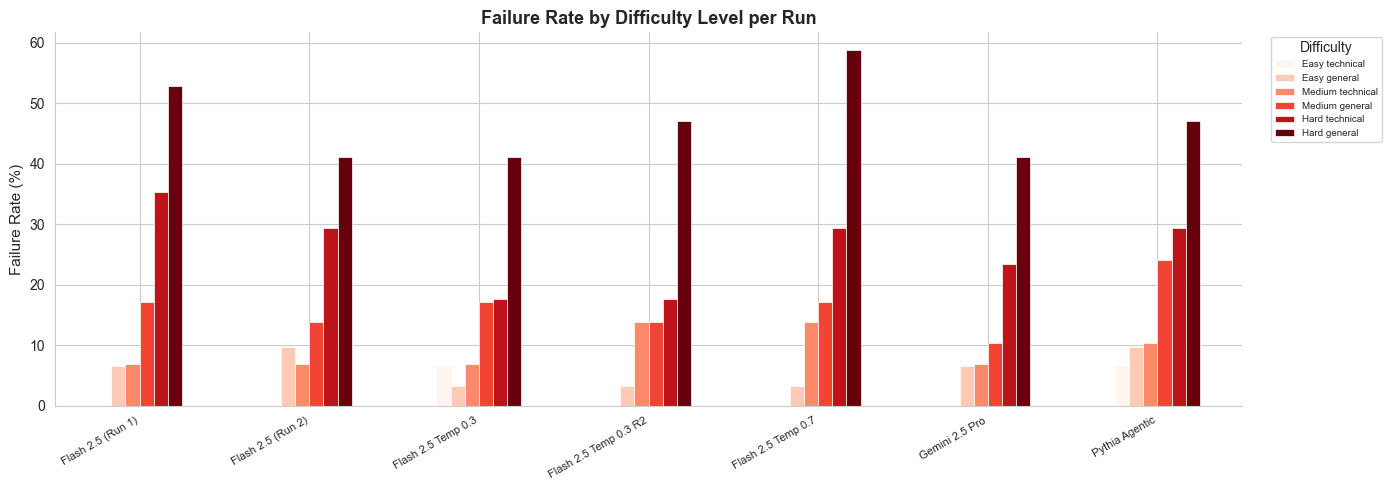


=== 10 Hardest Tasks (lowest avg F1 among failures) ===


,runs_failed,avg_f1,match_types,difficulty
task_id,,,,
2.1,1,0.0,no_overlap,Easy technical prompt
9.2,1,0.0,generated_empty,Medium general prompt
15.1,2,0.0,"no_overlap, generated_empty",Easy technical prompt
15.2,1,0.0,no_overlap,Easy general prompt
16.2,4,0.0,no_overlap,Hard general prompt
18.2,6,0.0,no_overlap,Hard general prompt
21.2,3,0.0,"no_overlap, generated_empty",Easy general prompt
24.2,1,0.0,no_overlap,Easy general prompt
32.1,7,0.0,no_overlap,Medium technical prompt


In [130]:
failures = df[~df["is_correct"]].copy()

#1. Failure match-type counts (overall across all runs)
fail_mt = (
    failures.groupby("match_type").size()
    .sort_values(ascending=False)
    .reset_index(name="count")
)
fail_mt["pct"] = (fail_mt["count"] / len(failures) * 100).round(1)
print("=== Failure Match-Type Breakdown (all runs) ===")
print(fail_mt.to_string(index=False))

# 2. Failure rate by difficulty level per run
diff_col = failures["difficulty"].str.replace(" prompt", "", regex=False)
fail_by_diff = (
    failures.assign(difficulty_short=diff_col)
    .groupby(["run", "difficulty_short"], observed=False)
    .size()
    .reset_index(name="fail_count")
)
total_by_diff = (
    df.assign(difficulty_short=df["difficulty"].str.replace(" prompt", "", regex=False))
    .groupby(["run", "difficulty_short"], observed=False)
    .size()
    .reset_index(name="total_count")
)
fail_rate = fail_by_diff.merge(total_by_diff, on=["run", "difficulty_short"])
fail_rate["fail_rate"] = (fail_rate["fail_count"] / fail_rate["total_count"] * 100).round(1)

fig, ax = plt.subplots(figsize=(14, 5))
fail_pivot = fail_rate.pivot(index="run", columns="difficulty_short", values="fail_rate").fillna(0)
diff_order_short = ["Easy technical", "Easy general", "Medium technical",
                    "Medium general", "Hard technical", "Hard general"]
fail_pivot = fail_pivot.reindex(index=RUN_ORDER, columns=[d for d in diff_order_short if d in fail_pivot.columns])
fail_pivot.plot.bar(ax=ax, colormap="Reds", edgecolor="white", linewidth=0.5)

ax.set_ylabel("Failure Rate (%)", fontsize=11)
ax.set_xlabel("")
ax.set_title("Failure Rate by Difficulty Level per Run", fontsize=13, fontweight="bold")
ax.set_xticklabels(RUN_ORDER, rotation=30, ha="right", fontsize=8)
ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left", fontsize=7, title="Difficulty")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.tight_layout()
plt.savefig("plot_8_failure_rate_by_difficulty.png", dpi=150, bbox_inches="tight")
plt.show()

# --- 3. Worst tasks (lowest avg F1 across runs) ---
worst = (
    failures.groupby("task_id")
    .agg(
        runs_failed=("run", "count"),
        avg_f1=("f1_score", "mean"),
        match_types=("match_type", lambda s: ", ".join(s.unique())),
        difficulty=("difficulty", "first"),
    )
    .sort_values("avg_f1")
    .head(10)
)
print("\n=== 10 Hardest Tasks (lowest avg F1 among failures) ===")
worst

**Analysis:**

The primary behaviors associated with unsuccessful queries are highlighted in the final failure table. Within the incorrect outputs, the `no_overlap` and `generated_failed` categories are most frequently observed. This suggests that failures are largely binary: instead of returning partial matches, the models either generate a completely unrelated query that returns no overlapping results, or they produce invalid syntax that causes the execution to crash. When separated by difficulty, **Hard general** prompts are shown to be the main point of failure. A failure rate exceeding $40\%$ is consistently observed for these prompts across all model configurations. Furthermore, the table of the hardest tasks confirms that certain complex prompts remain challenging for all evaluated models.